Can we predict the habitat type of a fungal species based on its taxonomic classification and observation details (such as the time of year)

In [ ]:
# First, let's load the uploaded fungi dataset to understand its structure and content.
import pandas as pd

# Load the dataset
dataset_path = '/content/drive/MyDrive/Colab Notebooks/COMP 6915 EA1/occurrences.csv'
data = pd.read_csv(dataset_path, encoding='ISO-8859-1')

# Display the first few rows of the dataset to get an overview of its content and structure
data.head()

,id,institutionCode,collectionCode,ownerInstitutionCode,basisOfRecord,occurrenceID,catalogNumber,otherCatalogNumbers,higherClassification,kingdom,...,verbatimDepth,verbatimElevation,disposition,language,recordEnteredBy,modified,sourcePrimaryKey-dbpk,collID,recordID,references
0,3077805,FNL,NaN,NaN,PreservedSpecimen,NaN,FI1-001,NaN,Fungi|Basidiomycota|Agaricomycotina|Agaricomyc...,Fungi,...,NaN,NaN,NaN,NaN,NaN,2016-08-24 00:00:00,NaN,62,3032814b-5234-4260-84b1-5d2885ec76aa,https://www.mycoportal.org/portal/collections/...
1,3077806,FNL,NaN,NaN,PreservedSpecimen,NaN,FI1-002,NaN,Fungi|Basidiomycota|Agaricomycotina|Agaricomyc...,Fungi,...,NaN,NaN,NaN,NaN,NaN,2016-08-24 00:00:00,NaN,62,b5fdc281-dd01-483d-8db9-579e9b249636,https://www.mycoportal.org/portal/collections/...
2,3077807,FNL,NaN,NaN,PreservedSpecimen,NaN,FI1-003,NaN,Fungi|Basidiomycota|Agaricomycotina|Agaricomyc...,Fungi,...,NaN,NaN,NaN,NaN,NaN,2016-08-24 00:00:00,NaN,62,e2ffbc21-886a-4f06-997f-f599dfcb28b1,https://www.mycoportal.org/portal/collections/...
3,3077808,FNL,NaN,NaN,PreservedSpecimen,NaN,FI1-004,NaN,Fungi|Basidiomycota|Ustilaginomycotina|Exobasi...,Fungi,...,NaN,NaN,NaN,NaN,NaN,2016-08-24 00:00:00,NaN,62,8f66f9c3-2442-45c4-8a03-8590a8030a41,https://www.mycoportal.org/portal/collections/...
4,3077809,FNL,NaN,NaN,PreservedSpecimen,NaN,FI1-005,NaN,Fungi|Basidiomycota|Agaricomycotina|Agaricomyc...,Fungi,...,NaN,NaN,NaN,NaN,titurri,2016-08-23 00:00:00,NaN,62,74a16b7f-ff46-42d3-a788-d3ad6ac852e2,https://www.mycoportal.org/portal/collections/...


In [ ]:
num_rows, num_cols = data.shape

print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

Number of rows: 6162
Number of columns: 97


In [ ]:
# Data Preparation for the classification model
# Select relevant features and the target variable
model_data = data[['family', 'genus', 'month', 'habitat']].dropna()

# Since the 'habitat' field is our target, let's check the distribution of its categories
habitat_distribution = model_data['habitat'].value_counts()

# focus on the top N categories and group the rest into 'Other'
top_habitats = habitat_distribution[:5].index.tolist()
model_data['habitat'] = model_data['habitat'].apply(lambda x: x if x in top_habitats else 'Other')

# Encoding categorical features and the target variable
model_data = pd.get_dummies(model_data, columns=['family', 'genus', 'month'], drop_first=True)

# Separating the features and target variable
X = model_data.drop('habitat', axis=1)
y = model_data['habitat']

# Displaying the distribution of the simplified habitat categories
model_data['habitat'].value_counts(), X.shape

(Other                2604
 Coniferous Woods      828
 coniferous woods      677
 Coniferous woods      506
 Coniferous forest     291
 Mixed woods           278
 Name: habitat, dtype: int64,
 (5184, 503))

In [ ]:
# Step 1: Identify inconsistent labels
print(y.unique())

# Step 2: Standardize Labels
y_standardized = y.str.lower()  # Convert to lowercase
y_standardized = y_standardized.str.strip()  # Remove leading and trailing spaces

y_standardized = y_standardized.replace({'coniferous forest': 'coniferous woods'})

# Verify the standardization
print(y_standardized.unique())

['Coniferous woods' 'Other' 'Coniferous forest' 'Mixed woods'
 'Coniferous Woods' 'coniferous woods']
['coniferous woods' 'other' 'mixed woods']


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Fit and transform the standardized labels to integer labels
y_encoded = label_encoder.fit_transform(y_standardized)

# Check the encoding
print(y_encoded[:5])

label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(label_mapping)

[0 2 2 2 2]
{'coniferous woods': 0, 'mixed woods': 1, 'other': 2}


In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, classification_report
import numpy as np

# Initialize the Random Forest Classifier
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Define stratified k-fold cross-validation configuration
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the accuracy as the evaluation metric
scoring = make_scorer(accuracy_score)

# Perform stratified k-fold cross-validation
cv_results = cross_val_score(random_forest_model, X, y_encoded, cv=kfold, scoring=scoring)

# Output the results
print(f"CV Accuracy Scores: {cv_results}")
print(f"Mean CV Accuracy: {np.mean(cv_results)}")


CV Accuracy Scores: [0.55351977 0.60559306 0.56412729 0.57859209 0.58204633]
Mean CV Accuracy: 0.576775708067897


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
import numpy as np

# Prepare the stratified k-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize metrics
accuracies = []
precision_list = []
recall_list = []
fscore_list = []

# Manual loop to perform stratified k-fold cross-validation
for train_index, test_index in kfold.split(X, y_encoded):
    # Split data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]

    # Initialize the model
    model = RandomForestClassifier(n_estimators=100, random_state=42)

    # Train the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Compute the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    # Compute detailed classification metrics
    precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average=None, labels=np.unique(y_encoded))
    precision_list.append(precision)
    recall_list.append(recall)
    fscore_list.append(fscore)

# Print average of the metrics
print(f"Mean Accuracy: {np.mean(accuracies)}")
print(f"Mean Precision per class: {np.mean(precision_list, axis=0)}")
print(f"Mean Recall per class: {np.mean(recall_list, axis=0)}")
print(f"Mean F-Score per class: {np.mean(fscore_list, axis=0)}")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Mean Accuracy: 0.576775708067897
Mean Precision per class: [0.54023585 0.19166667 0.62373054]
Mean Recall per class: [0.66766198 0.01084416 0.55684925]
Mean F-Score per class: [0.59706583 0.02014641 0.58815674]


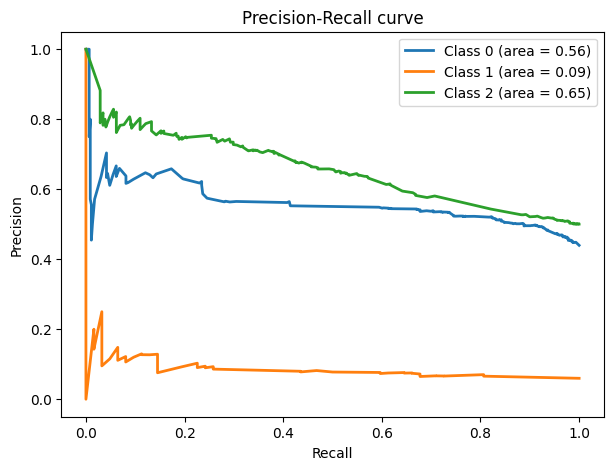

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np

# Binarize the output
y_bin = label_binarize(y_encoded, classes=np.unique(y_encoded))
n_classes = y_bin.shape[1]

# Split data into training and test sets
X_train, X_test, y_train_bin, y_test_bin = train_test_split(X, y_bin, test_size=0.2, random_state=42)

# Train the Random Forest model
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train_bin)

# Predict probabilities for each class
y_score = classifier.predict_proba(X_test)

# Compute Precision-Recall and plot curve
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[i][:, 1])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_score[i][:, 1])

# Plot the Precision-Recall curve for each class
plt.figure(figsize=(7, 5))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label='Class {0} (area = {1:0.2f})'.format(i, average_precision[i]))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.title("Precision-Recall curve")
plt.show()


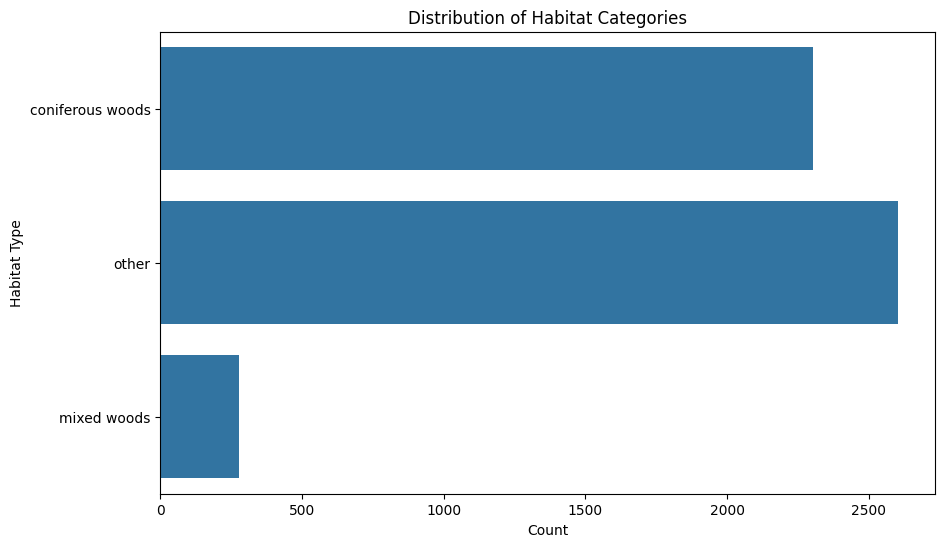

<Figure size 1400x800 with 0 Axes>

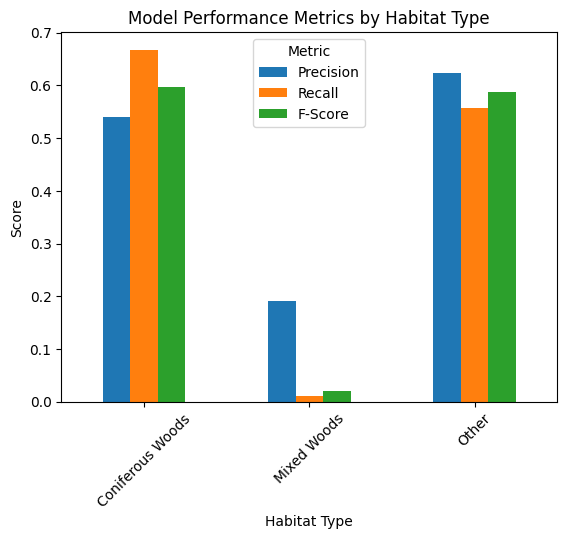

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization 1: Distribution of Habitat Categories
plt.figure(figsize=(10, 6))
sns.countplot(y=y_standardized)
plt.title('Distribution of Habitat Categories')
plt.xlabel('Count')
plt.ylabel('Habitat Type')
plt.show()

# Prepare data for Visualization 2
performance_metrics = {
    'Habitat Type': ['Coniferous Woods', 'Mixed Woods', 'Other'],
    'Precision': np.mean(precision_list, axis=0),
    'Recall': np.mean(recall_list, axis=0),
    'F-Score': np.mean(fscore_list, axis=0)
}
performance_df = pd.DataFrame(performance_metrics)

# Visualization 2: Performance Metrics by Habitat Type
plt.figure(figsize=(14, 8))
performance_df.set_index('Habitat Type').plot(kind='bar')
plt.title('Model Performance Metrics by Habitat Type')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(title='Metric')
plt.show()


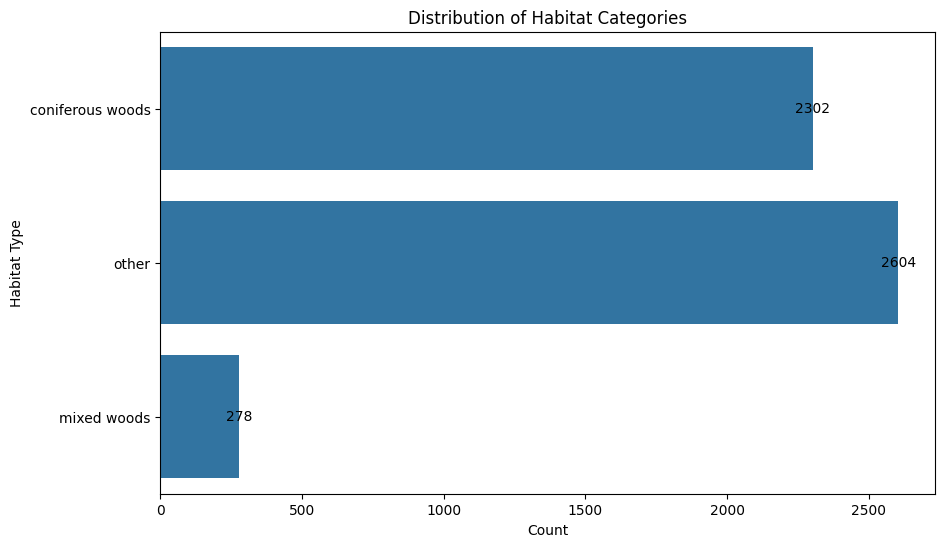

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a count plot for habitat categories
plt.figure(figsize=(10, 6))
ax = sns.countplot(y=y_standardized)
plt.title('Distribution of Habitat Categories')
plt.xlabel('Count')
plt.ylabel('Habitat Type')

# Annotate each bar with the count
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', (p.get_width() + 0.1, p.get_y() + p.get_height() / 2),
                ha = 'center', va = 'center',
                xytext = (0, 0),
                textcoords = 'offset points')

plt.show()


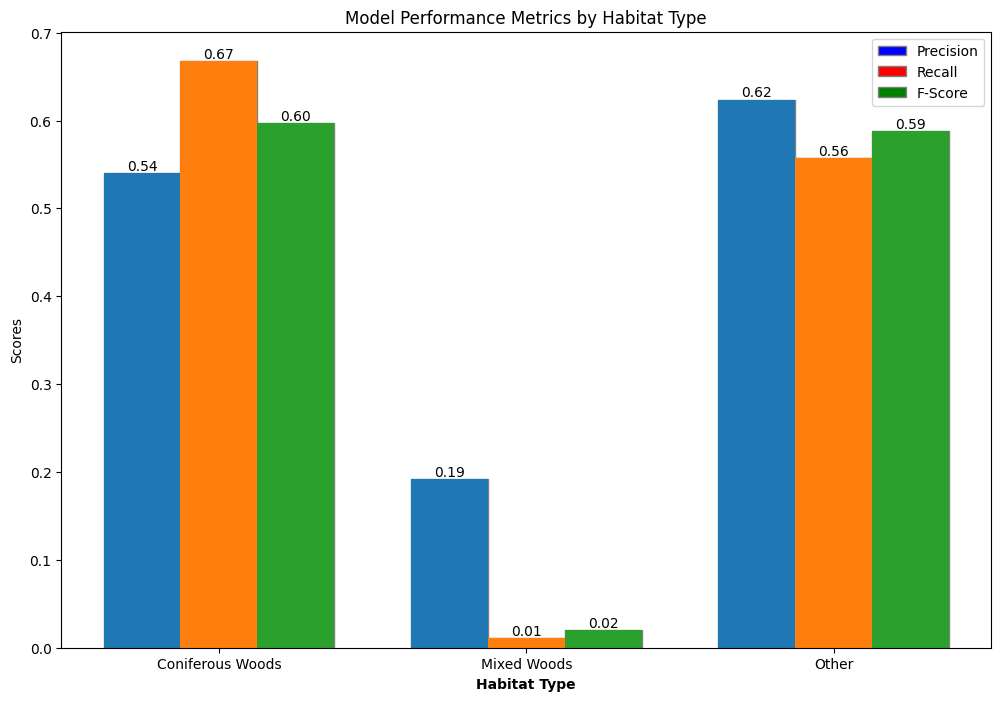

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming performance_df is your DataFrame with the performance metrics
categories = performance_df['Habitat Type'].unique()
metrics = ['Precision', 'Recall', 'F-Score']
n_categories = len(categories)
n_metrics = len(metrics)

# Positions of the bars on the x-axis
barWidth = 0.25
r1 = np.arange(n_categories)
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Create the bars
plt.figure(figsize=(12, 8))
plt.bar(r1, performance_df['Precision'], color='b', width=barWidth, edgecolor='grey', label='Precision')
plt.bar(r2, performance_df['Recall'], color='r', width=barWidth, edgecolor='grey', label='Recall')
plt.bar(r3, performance_df['F-Score'], color='g', width=barWidth, edgecolor='grey', label='F-Score')

# Add xticks on the middle of the group bars
plt.xlabel('Habitat Type', fontweight='bold')
plt.xticks([r + barWidth for r in range(n_categories)], categories)

# Annotate bars
def annotate_bars(bars):
    for bar in bars:
        height = bar.get_height()
        plt.annotate('%.2f' % height,
                     (bar.get_x() + bar.get_width() / 2, height),
                     ha='center', va='bottom')

bars = plt.bar(r1, performance_df['Precision'], width=barWidth)
annotate_bars(bars)
bars = plt.bar(r2, performance_df['Recall'], width=barWidth)
annotate_bars(bars)
bars = plt.bar(r3, performance_df['F-Score'], width=barWidth)
annotate_bars(bars)

plt.ylabel('Scores')
plt.title('Model Performance Metrics by Habitat Type')
plt.legend()
plt.show()


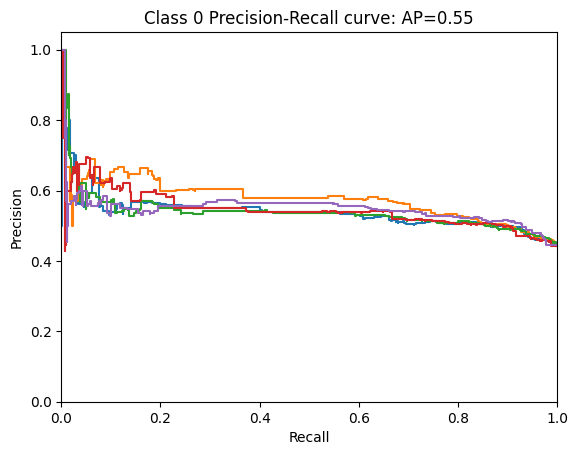

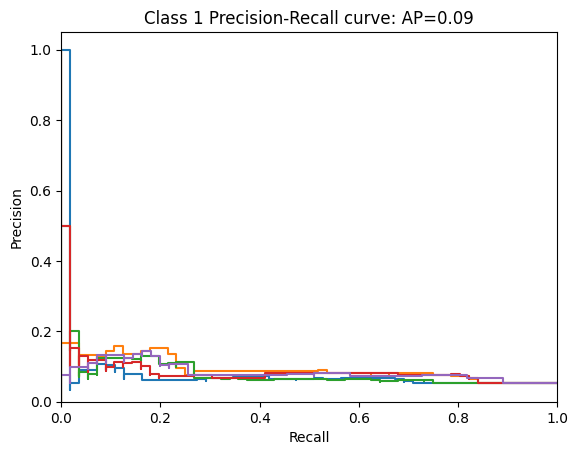

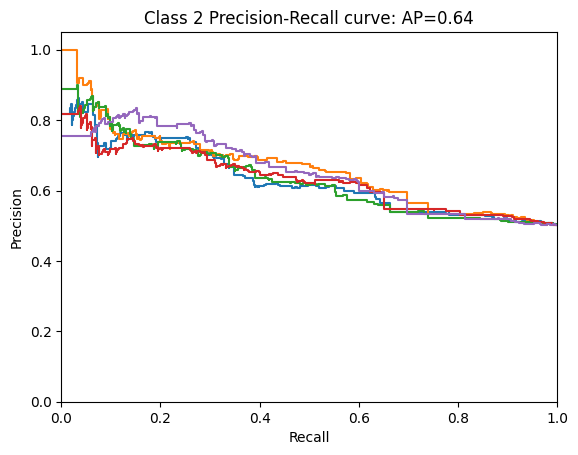

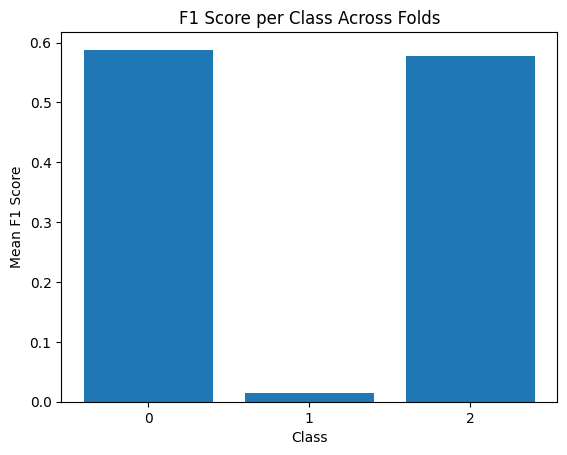

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve, average_precision_score, f1_score
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np

# Binarize the labels for a one-vs-rest approach
y_binarized = label_binarize(y_encoded, classes=np.unique(y_encoded))
n_classes = y_binarized.shape[1]

# Initialize the stratified k-fold configuration
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store per-fold metrics
precision_list = [[] for _ in range(n_classes)]
recall_list = [[] for _ in range(n_classes)]
average_precision_list = [[] for _ in range(n_classes)]
f1_scores_list = [[] for _ in range(n_classes)]

# Manually perform stratified k-fold cross-validation
for train_index, test_index in kfold.split(X, y_encoded):
    # Split the data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_binarized[train_index], y_binarized[test_index]

    # Initialize and train the Random Forest model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Predict probabilities and classes
    y_score = model.predict_proba(X_test)
    y_pred = model.predict(X_test)

    # Compute metrics for each class
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_test[:, i], y_score[i][:, 1])
        precision_list[i].append(precision)
        recall_list[i].append(recall)
        average_precision_list[i].append(average_precision_score(y_test[:, i], y_score[i][:, 1]))
        f1_scores_list[i].append(f1_score(y_test[:, i], y_pred[:, i]))

# Calculate average metrics across folds
average_precision = [np.mean(ap) for ap in average_precision_list]
mean_f1_scores = [np.mean(f1) for f1 in f1_scores_list]

# Plot the Precision-Recall curve for each class
for i in range(n_classes):
    plt.figure()
    for j in range(len(precision_list[i])):
        plt.step(recall_list[i][j], precision_list[i][j], where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f'Class {i} Precision-Recall curve: AP={average_precision[i]:0.2f}')
    plt.show()


# Plot F1 scores for each class
plt.bar(range(n_classes), mean_f1_scores)
plt.xlabel('Class')
plt.ylabel('Mean F1 Score')
plt.title('F1 Score per Class Across Folds')
plt.xticks(range(n_classes))
plt.show()


In [ ]:
import pandas as pd

# Classification report data
data = {
    "Precision": [0.54, 0.25, 0.64, None, 0.48, 0.57],
    "Recall": [0.71, 0.02, 0.53, 0.58, 0.42, 0.58],
    "F1-Score": [0.61, 0.03, 0.58, None, 0.41, 0.56],
    "Support": [456, 62, 519, 1037, None, None]
}

# Classes and metrics
rows = ["coniferous woods", "mixed woods", "other", "Accuracy", "Macro Avg", "Weighted Avg"]

# Create the DataFrame
classification_report_df = pd.DataFrame(data, index=rows)

# Display the table
classification_report_df


,Precision,Recall,F1-Score,Support
coniferous woods,0.54,0.71,0.61,456.0
mixed woods,0.25,0.02,0.03,62.0
other,0.64,0.53,0.58,519.0
Accuracy,NaN,0.58,NaN,1037.0
Macro Avg,0.48,0.42,0.41,NaN
Weighted Avg,0.57,0.58,0.56,NaN
